<a href="https://colab.research.google.com/github/NehaAgg245/ML-git/blob/master/Weather_load_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving UTDWeather_load_v1.csv to UTDWeather_load_v1.csv


In [0]:
import pandas as pd 
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from pandas import concat
from itertools import islice
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import io
from itertools import islice
from datetime import datetime

#Import Data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

weather_data = pd.read_csv(io.StringIO(uploaded['UTDWeather_load_v1.csv'].decode('utf-8')),parse_dates = [['Year', 'Month', 'Day', 'Hour']], index_col = 0, date_parser = parse)
weather_data.index.name = 'Date'
print(weather_data.head())

Using TensorFlow backend.


                     DHI  DNI  GHI  Clearsky DHI  Clearsky DNI  Clearsky GHI  \
Date                                                                           
2014-01-01 00:00:00    0    0    0             0             0             0   
2014-01-01 01:00:00    0    0    0             0             0             0   
2014-01-01 02:00:00    0    0    0             0             0             0   
2014-01-01 03:00:00    0    0    0             0             0             0   
2014-01-01 04:00:00    0    0    0             0             0             0   

                     Cloud Type  Dew Point  Temperature     Pressure  \
Date                                                                   
2014-01-01 00:00:00           0  -1.259314     1.801935  1001.034851   
2014-01-01 01:00:00           0  -1.251990     1.385065  1000.495544   
2014-01-01 02:00:00           0  -1.258856     1.022241   999.998657   
2014-01-01 03:00:00           0  -1.260016     0.723383   999.362183   
2014-01

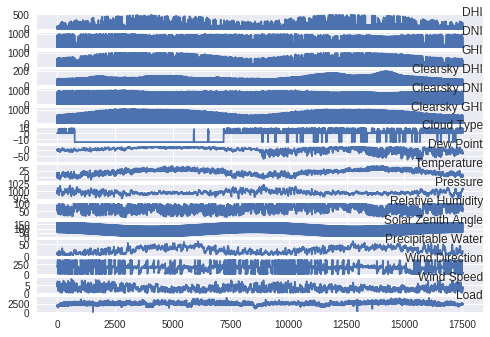

In [0]:
values = weather_data.values
groups = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
i = 1
plt.figure()
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title(weather_data.columns[group], y = 0.5, loc = 'right')
  i += 1
plt.show()

In [0]:
#Scaling - normalizing of data
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(values)
print(scaled[0])
print(scaled[1])
print(scaled[2])


[0.         0.         0.         0.         0.         0.
 0.625      0.76120926 0.22472925 0.54579724 0.77923289 0.99759647
 0.08987756 0.51145196 0.48602993 0.40344266]
[0.         0.         0.         0.         0.         0.
 0.625      0.76127221 0.21726155 0.53466494 0.80669101 0.95716538
 0.09601621 0.51896376 0.48996811 0.40344266]
[0.         0.         0.         0.         0.         0.
 0.625      0.7612132  0.21076202 0.52440827 0.83044351 0.8849297
 0.10259956 0.5242427  0.49795959 0.40109582]


In [0]:
#Converting the dataset into supervised dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  for i in range(n_in, 0 , -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  agg = concat(cols, axis = 1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace = True)
  return agg

reframed = series_to_supervised(scaled, 1,1)
reframed.drop(reframed.columns[[16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]],axis = 1, inplace = True)
print(reframed.head())
reframed_without_rfe = reframed
print(reframed_without_rfe.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1      0.625   0.761209   0.224729    0.545797    0.779233    0.997596   
2      0.625   0.761272   0.217262    0.534665    0.806691    0.957165   
3      0.625   0.761213   0.210762    0.524408    0.830444    0.884930   
4      0.625   0.761203   0.205408    0.511270    0.850840    0.807480   
5      0.625   0.761405   0.201652    0.501216    0.867183    0.729369   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var16(t)  
1    0.089878    0.511452    0.486030    0.403443  0.403443  
2   

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

X = reframed.values[:,0:-1]
y = reframed.values[:,-1]

estimator = RandomForestRegressor(n_estimators=500, random_state=1)
selector = RFE(estimator)
rfe = selector.fit(X, y) 
rfe.ranking_

array([8, 9, 5, 6, 1, 1, 7, 1, 1, 3, 2, 1, 1, 1, 4, 1])

In [0]:
reframed.drop(reframed.columns[[0,1,2,3,6,9,10,15]],axis = 1, inplace = True)
print(reframed.head())
print(reframed_without_rfe.head())

   var5(t-1)  var6(t-1)  var8(t-1)  var9(t-1)  var12(t-1)  var13(t-1)  \
1        0.0        0.0   0.761209   0.224729    0.997596    0.089878   
2        0.0        0.0   0.761272   0.217262    0.957165    0.096016   
3        0.0        0.0   0.761213   0.210762    0.884930    0.102600   
4        0.0        0.0   0.761203   0.205408    0.807480    0.111509   
5        0.0        0.0   0.761405   0.201652    0.729369    0.124764   

   var14(t-1)  var15(t-1)  var16(t)  
1    0.511452    0.486030  0.403443  
2    0.518964    0.489968  0.401096  
3    0.524243    0.497960  0.401656  
4    0.525849    0.509530  0.402909  
5    0.529370    0.523113  0.409145  
   var5(t-1)  var6(t-1)  var8(t-1)  var9(t-1)  var12(t-1)  var13(t-1)  \
1        0.0        0.0   0.761209   0.224729    0.997596    0.089878   
2        0.0        0.0   0.761272   0.217262    0.957165    0.096016   
3        0.0        0.0   0.761213   0.210762    0.884930    0.102600   
4        0.0        0.0   0.761203   0.20

In [0]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X , train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:,:-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1 , test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (8759, 1, 8) (8759,)


In [0]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='sgd')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
print(test_X.shape)

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


In [0]:
print(reframed_without_rfe.head())
values_without_rfe = reframed_without_rfe.values
print(values_without_rfe.shape)
n_train_hours_without_rfe = 365 * 24
train_without_rfe = values_without_rfe[:n_train_hours_without_rfe, :]
test_without_rfe = values_without_rfe[n_train_hours_without_rfe:, :]
train_X_without_rfe , train_y_without_rfe = train_without_rfe[:, :-1], train_without_rfe[:, -1]
test_X_without_rfe, test_y_without_rfe = test_without_rfe[:,:-1], test_without_rfe[:, -1]
train_X_without_rfe = train_X_without_rfe.reshape((train_X_without_rfe.shape[0], 1, train_X_without_rfe.shape[1]))
test_X_without_rfe = test_X_without_rfe.reshape((test_X_without_rfe.shape[0], 1 , test_X_without_rfe.shape[1]))
print(train_X_without_rfe.shape, train_y_without_rfe.shape, test_X_without_rfe.shape, test_y_without_rfe.shape)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  \
1      0.625   0.761209   0.224729    0.545797    0.779233    0.997596   
2      0.625   0.761272   0.217262    0.534665    0.806691    0.957165   
3      0.625   0.761213   0.210762    0.524408    0.830444    0.884930   
4      0.625   0.761203   0.205408    0.511270    0.850840    0.807480   
5      0.625   0.761405   0.201652    0.501216    0.867183    0.729369   

   var13(t-1)  var14(t-1)  var15(t-1)  var16(t-1)  var16(t)  
1    0.089878    0.511452    0.486030    0.403443  0.403443  
2   

In [0]:
from numpy import concatenate
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
test_X_without_rfe = test_X_without_rfe.reshape((test_X_without_rfe.shape[0], test_X_without_rfe.shape[2]))
print(test_X.shape)

(8759, 1, 8)
(8759, 1, 8)


In [0]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_without_rfe[:, 1:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y_without_rfe = test_y_without_rfe.reshape((len(test_y_without_rfe), 1))
inv_y = concatenate((test_y_without_rfe, test_X_without_rfe[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(8759, 16)
Test RMSE: 46.816


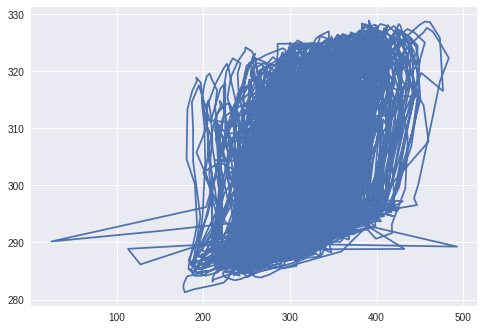

In [0]:
plt.plot(inv_y, inv_yhat)
plt.show()